<a href="https://colab.research.google.com/github/YasminaNasser/Barcode_Reader/blob/main/CVProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Guidelines
## 1- Determine our flags
### - Rotation Flag
### - Blurred Flag
### - salt & Pepper Flag
### - High brightness Flag
### - Low brightness Flag
### - Frequency Flag
### - Obstacle on barcode Flag
### - Barcode ma2toush Flag
### - wen el contrast Flag
## 2- Define Functions that raise flag
## 3- Preprocessing Functions




#Imports


In [ ]:
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import math
from scipy import fftpack



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Read the image


(600, 800, 3)


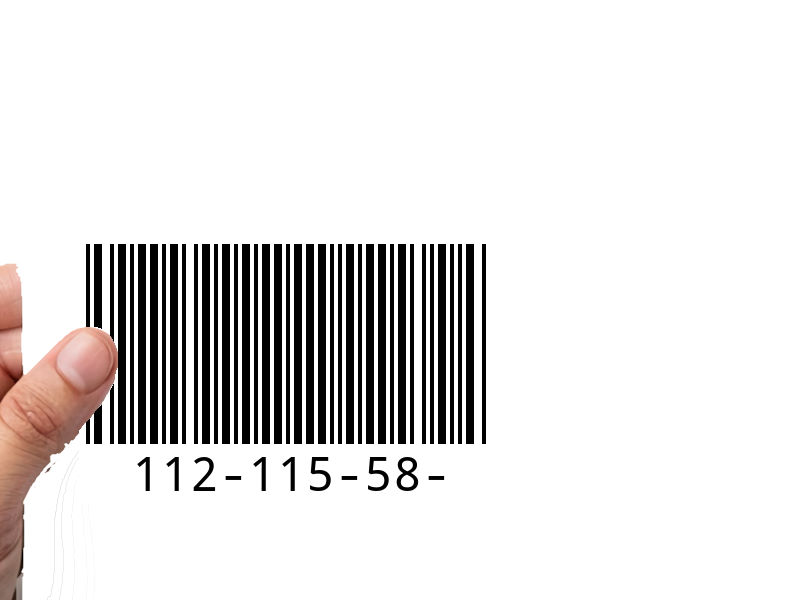

In [ ]:
img = cv2.imread("/content/all_images/03 - eda ya3am ew3a soba3ak mathazarsh.jpg")
print(img.shape)
cv2_imshow(img)


In [ ]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Set all non-black and non-white pixels to white

gray[(gray >= 20) & (gray <= 220)] = 255
cv2_imshow(gray)
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))
cv2_imshow(gray)


gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 200)))
cv2_imshow(gray)


NameError: name 'img' is not defined

(600, 800, 3)


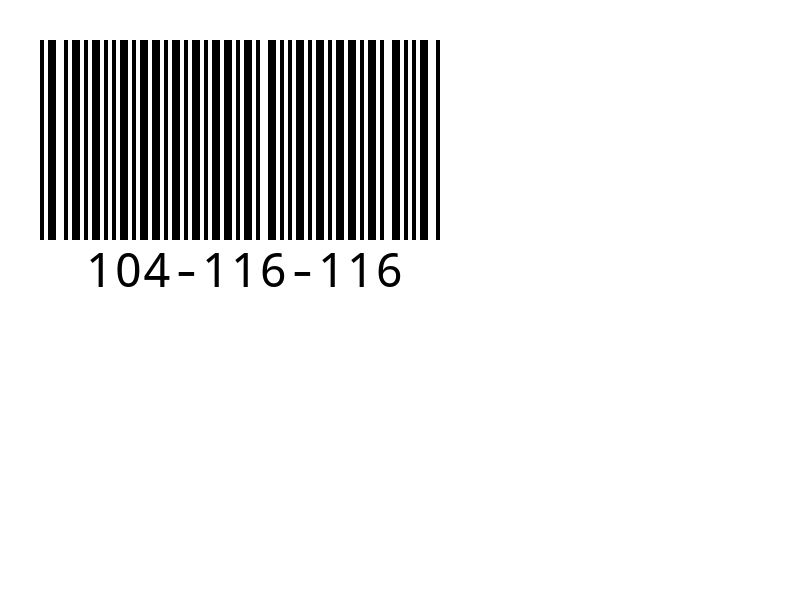

In [ ]:
img = cv2.imread("/content/all_images/02 - still easy.jpg")
print(img.shape)
cv2_imshow(img)



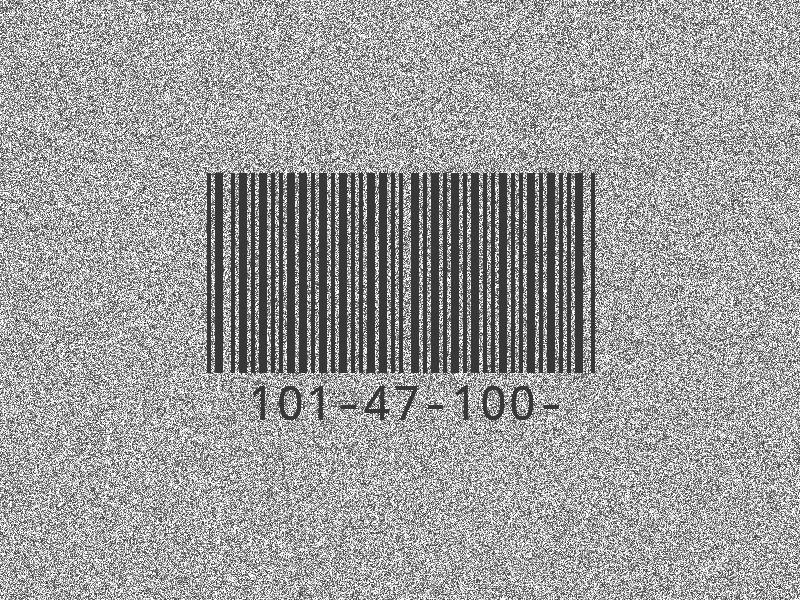

In [ ]:
img = cv2.imread("/content/all_images/07 - mal7 w felfel.jpg")
cv2_imshow(img)

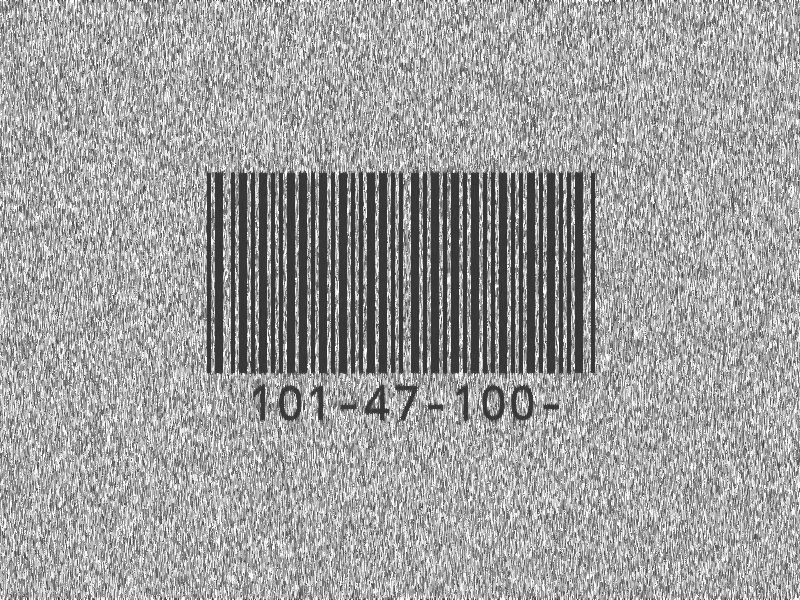

In [ ]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def median_filter_vertical(image, kernel_size):

    # Ensure the kernel size is odd
    if kernel_size % 2 == 0:
        kernel_size += 1

    # Create an empty image for the result
    filtered_image = image.copy()

    # Apply median filter column by column
    rows, cols = image.shape
    for col in range(cols):
        # Apply the median filter on each column
        filtered_image[:, col] = cv2.medianBlur(image[:, col].reshape(-1, 1), kernel_size).flatten()

    return filtered_image

# Set the kernel size (odd number)
kernel_size = 5

# Apply vertical median filter
filtered_image = median_filter_vertical(gray, kernel_size)

cv2_imshow(filtered_image)


#Helper Functions


In [ ]:
def contour(image):
  inv= cv2.bitwise_not(image)
  x,y,w,h=cv2.boundingRect(inv)
  crop=image[y:y+h-h//4,x:x+w]
  return crop

def calculate_vertical_bar_height(image):
    contoured = contour(image)
    if len(contoured.shape) == 2:  # Grayscale image
        height, _ = contoured.shape
    else:  # Color image
        height, _, _ = contoured.shape
    return height

def apply_closing(image, bar_height):
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))
    return closed_image

def apply_opening(image, bar_height):
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (2, bar_height)))
    return opened_image


# badr assiting functions

In [ ]:
def fill_connected_regions(binary_image, start_points, fill_color=255):


    # Create a mask for flood filling
    h, w = binary_image.shape
    mask = np.zeros((h + 2, w + 2), dtype=np.uint8)  # Mask needs to be 2 pixels larger than the image

    # Copy the binary image to avoid modifying the original
    filled_image = binary_image.copy()

    # Loop over each start point and apply flood fill
    for x, y in start_points:
        if filled_image[y, x] == 0:  # Ensure we only start filling from black regions
            cv2.floodFill(filled_image, mask, (x, y), fill_color)

    return filled_image

def remove_corner_lines(image, kernel_size=(3, 3), threshold_value=127):
    # Load the image

    # Threshold the image to create a binary version
    _, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY_INV)

    # Create a kernel for opening
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

    # Apply morphological opening
    opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    # Invert the image back to the original format
    result_image = cv2.bitwise_not(opened_image)

    return result_image




In [ ]:
  #contour Rotated
def contour_rotated(img):
    padded_image = cv2.copyMakeBorder(img, 100, 100, 200, 200, cv2.BORDER_CONSTANT, value=[255, 255, 255])  # White padding

    ret,thresh = cv2.threshold(padded_image,127,255,0)

    thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)

    cnt = contours[35]
    M = cv2.moments(cnt)
    print( M )
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    angle=rect[2]
    print(angle)

    (height, width) = thresh.shape[:2]

    # Define the center of rotation
    center = (width // 2, height // 2)

    # Define the angle of rotation and scaling factor
    scale = 1.0  # No scaling

    # Generate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle-90, scale)

    # Perform the rotation
    rotated_image = cv2.warpAffine(thresh, rotation_matrix, (width, height))

    # fill the black corners
    rotated_image = fill_connected_regions(rotated_image, [(0, 0)])
    rotated_image = fill_connected_regions(rotated_image, [(0, height-1)])
    rotated_image = fill_connected_regions(rotated_image, [(width-1, 0)])
    rotated_image = fill_connected_regions(rotated_image, [(width-1, height-1)])

    # opening on the lines after filling
    rotated_image = remove_corner_lines(rotated_image)

    #contour
    rotated_image = contour(rotated_image)

    #closing (opening because inverted)
    height, width = rotated_image.shape
    final_image = apply_opening(rotated_image, height)

    return final_image



image = cv2.imread("/content/all_images/09 - e3del el soora ya3ammm.jpg")
imgf = contour_rotated(image)
cv2_imshow(imgf)








AttributeError: 'NoneType' object has no attribute 'clip'

#DETECTION FUNCTIONS

#Assisting functions

loop function

In [ ]:
def print_results(function_name):
  folder_path = '/content/all_images'
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)

      if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
          image = cv2.imread(file_path)
          image = grey_scale(image)
          print(file_path + ' - ' +  function_name(image))



gaussian

In [ ]:
def apply_gaussian(image , count = 1):
  gaussian_kernel = np.array([[1, 2, 1],
                             [2, 4, 2],
                             [1, 2, 1]], dtype=np.float32)
  gaussian_kernel /= np.sum(gaussian_kernel)

  filtered_image = image
  for i in range(count):
    filtered_image = cv2.filter2D(image, -1, gaussian_kernel)

  return filtered_image



# Detect Blur


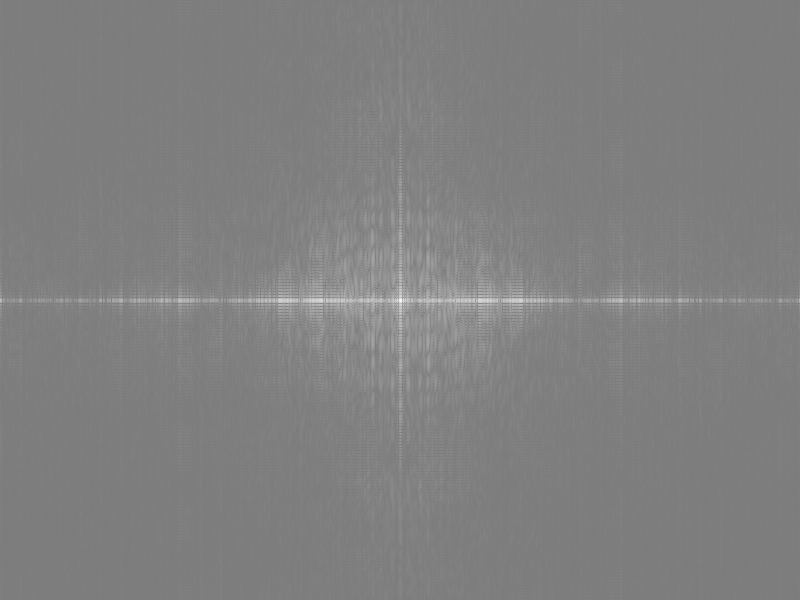

avgroi = 175 corners_avg = 125.75
/content/all_images/10 - wen el kontraastttt.jpg - False


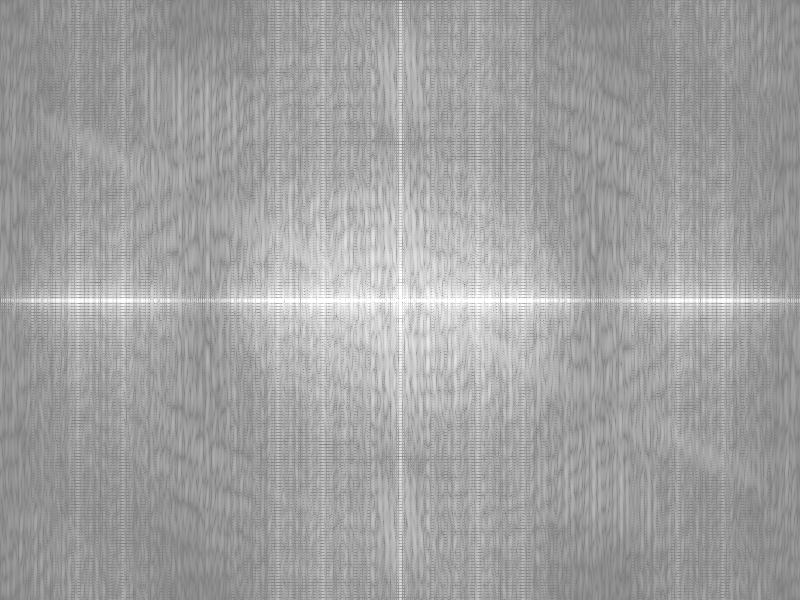

avgroi = 244 corners_avg = 140.5
/content/all_images/02 - still easy.jpg - False


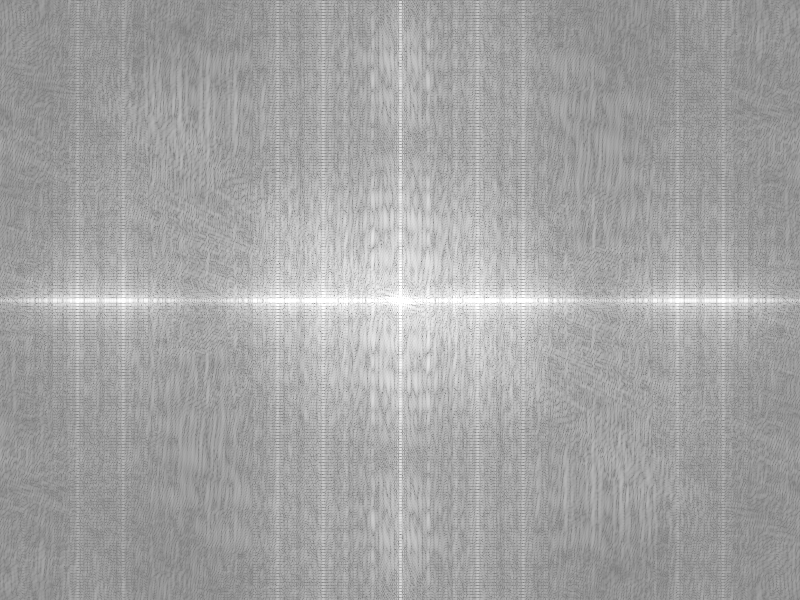

avgroi = 252 corners_avg = 144.5
/content/all_images/03 - eda ya3am ew3a soba3ak mathazarsh.jpg - False


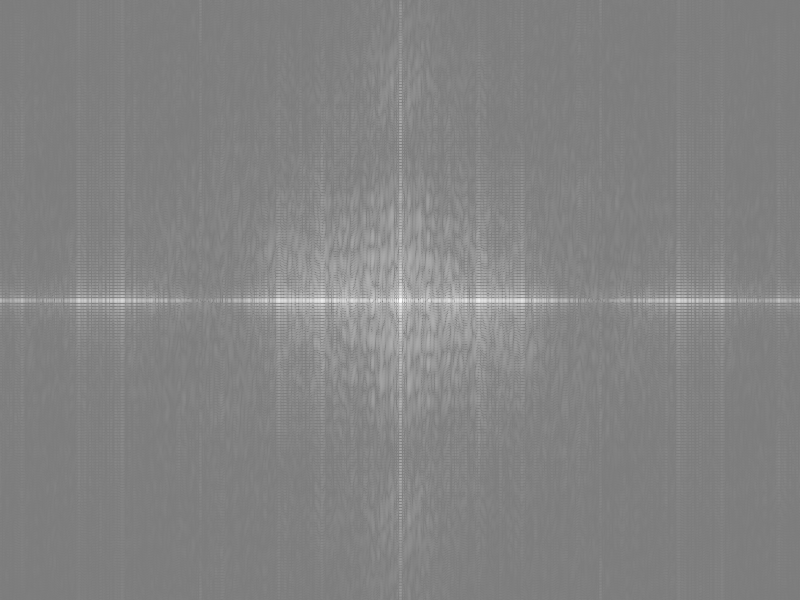

avgroi = 191 corners_avg = 125.75
/content/all_images/06 - meen fata7 el nour 333eenaaayy.jpg - False


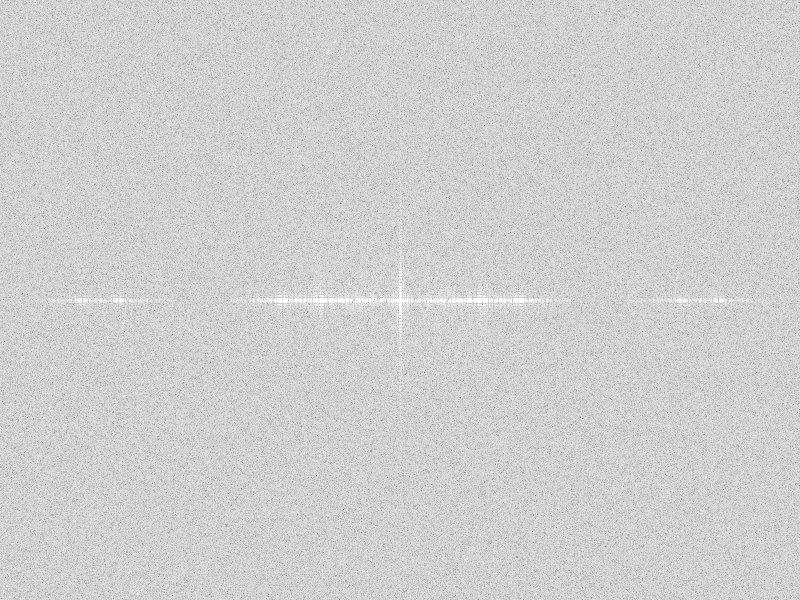

avgroi = 232 corners_avg = 207.75
/content/all_images/07 - mal7 w felfel.jpg - False


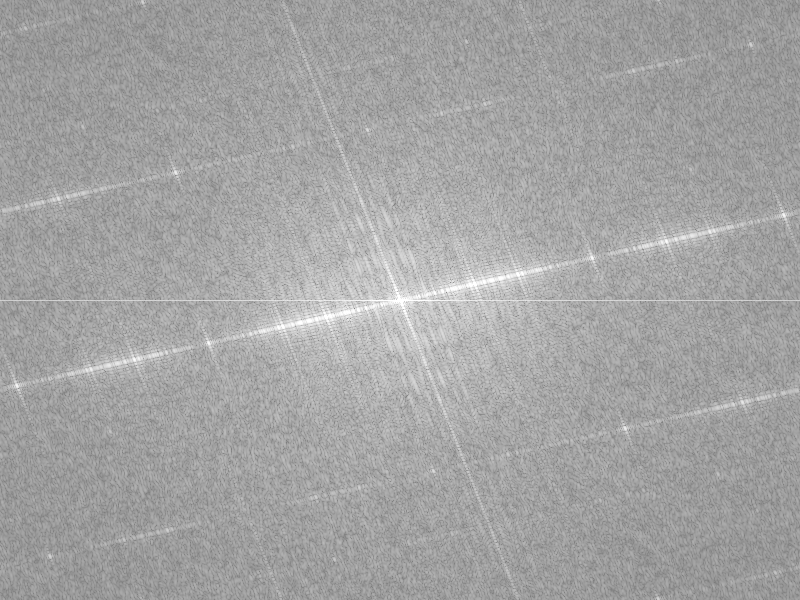

avgroi = 232 corners_avg = 150.25
/content/all_images/11 - bayza 5ales di bsara7a.jpg - False


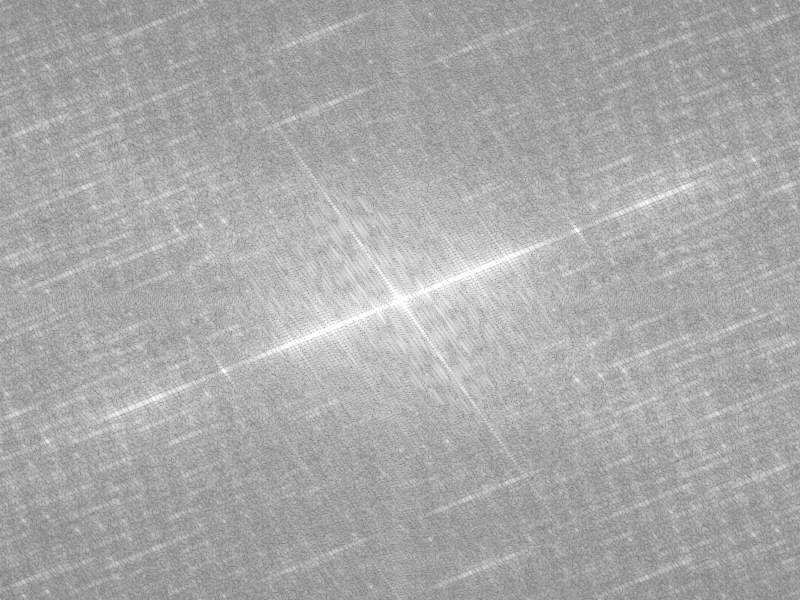

avgroi = 248 corners_avg = 154.5
/content/all_images/09 - e3del el soora ya3ammm.jpg - False


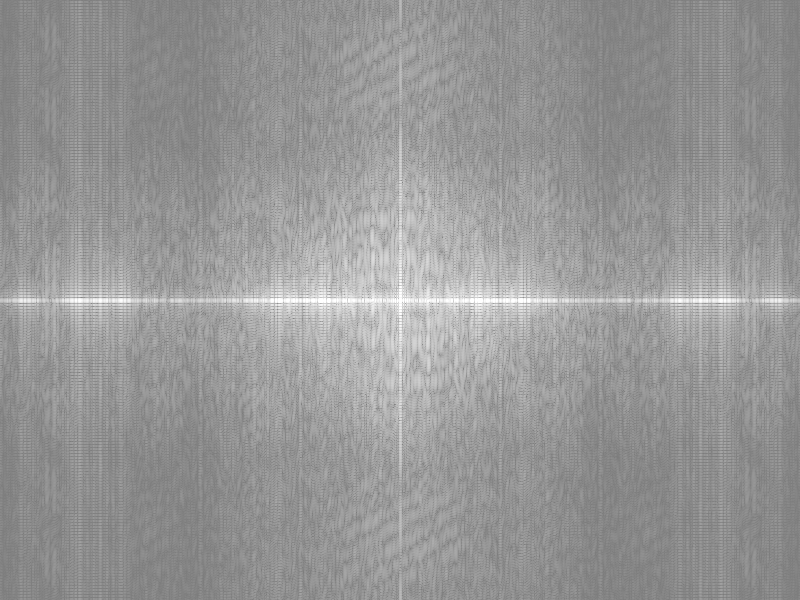

avgroi = 228 corners_avg = 130.25
/content/all_images/08 - compresso espresso.jpg - False


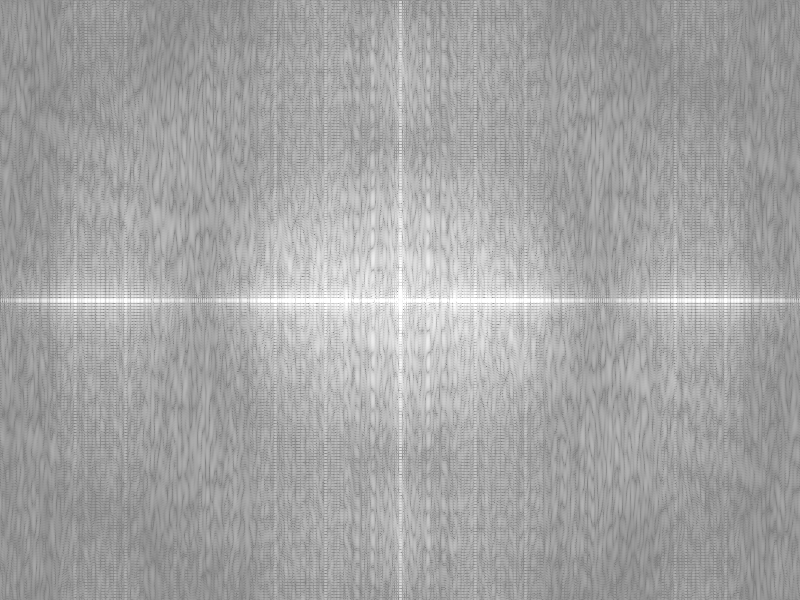

avgroi = 243 corners_avg = 146.0
/content/all_images/01 - lol easy.jpg - False


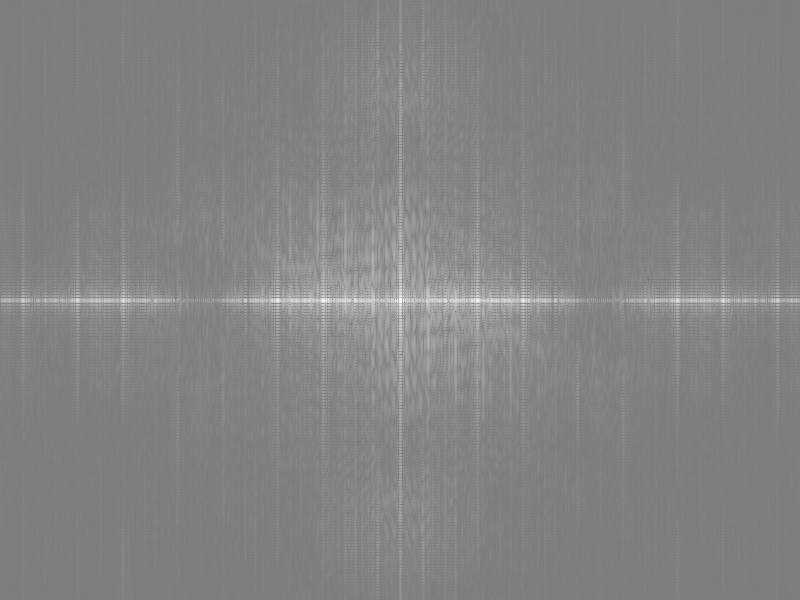

avgroi = 187 corners_avg = 126.0
/content/all_images/05 - meen taffa el nour!!!.jpg - False


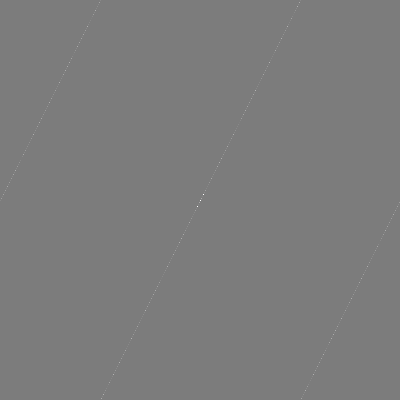

avgroi = 126 corners_avg = 124.0
/content/all_images/sine2.png - False


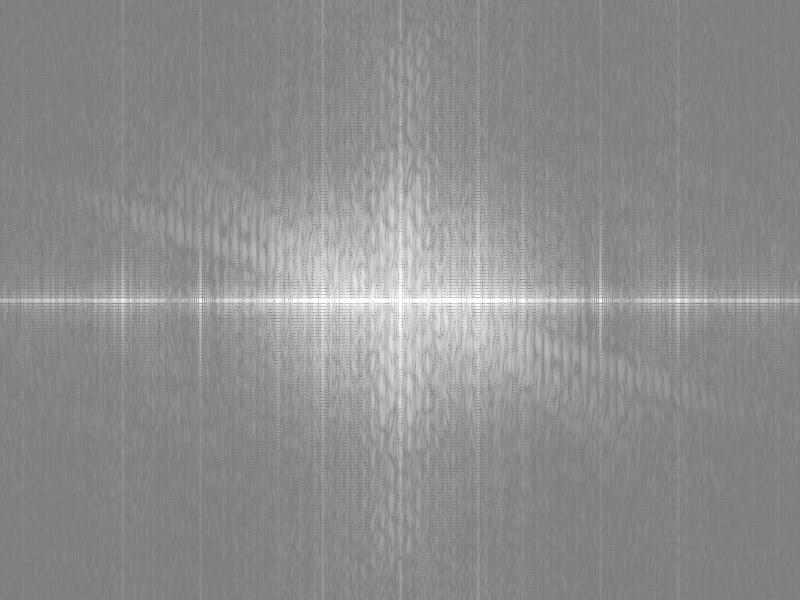

avgroi = 237 corners_avg = 127.5
/content/all_images/04 - fen el nadara.jpg - False


In [ ]:
def detect_blurred(image):
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)

    magnitude_spectrum = 20*np.log(np.abs(f_transform_shifted)+ 500)
    cv2_imshow(magnitude_spectrum)
    rows, cols = image.shape
    center_row = rows // 2
    center_col = cols // 2
    roi_size = 9
    #dc_component = magnitude_spectrum[center_row, center_col]
    roi = magnitude_spectrum[center_row - roi_size:center_row + roi_size + 1,
                              center_col - roi_size:center_col + roi_size + 1]
    avg_roi = round(np.mean(roi))
    corner1_avg = round(np.mean(magnitude_spectrum[0:10, 0:10]))
    corner2_avg = round(np.mean(magnitude_spectrum[0:10, -10:]))
    corner3_avg = round(np.mean(magnitude_spectrum[-10:, 0:10]))
    corner4_avg = round(np.mean(magnitude_spectrum[-10:, -10:]))
    corners_avg = (corner1_avg + corner2_avg + corner3_avg + corner4_avg) / 4


    print("avgroi = " + str(avg_roi) + " corners_avg = " + str(corners_avg))



    if(np.mean(magnitude_spectrum[100:-100, 100:-100])== float('-inf')):
        return "FalseINF"

    low_avg_threshold = 227
    high_avg_threshold = 100
    laplacian_kernel = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])

    if(avg_roi > low_avg_threshold and corners_avg < high_avg_threshold):
        # cv2_imshow(image)
        # laplacian_image = cv2.filter2D(image, -1, laplacian_kernel)
        # cv2_imshow(laplacian_image)
        return "True"
    else:
        return "False"


print_results(detect_blurred)

# Detect Contrast

In [ ]:
def detect_contrast(image):
  pixel_ratio = 0.8
  lower_bound = 100
  upper_bound = 200

  histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
  histogram = histogram / histogram.sum()

  grey_pixel_ratio = histogram[lower_bound:upper_bound].sum()
  if grey_pixel_ratio > pixel_ratio:
    return 'True'
  else:
    return "False"

print_results(detect_contrast)

/content/all_images/10 - wen el kontraastttt.jpg - True
/content/all_images/02 - still easy.jpg - False
/content/all_images/03 - eda ya3am ew3a soba3ak mathazarsh.jpg - False
/content/all_images/06 - meen fata7 el nour 333eenaaayy.jpg - False
/content/all_images/07 - mal7 w felfel.jpg - False
/content/all_images/11 - bayza 5ales di bsara7a.jpg - False
/content/all_images/09 - e3del el soora ya3ammm.jpg - False
/content/all_images/08 - compresso espresso.jpg - False
/content/all_images/01 - lol easy.jpg - False
/content/all_images/05 - meen taffa el nour!!!.jpg - False
/content/all_images/04 - fen el nadara.jpg - False


In [ ]:
img = cv2.imread("/content/testcase/01 - lol easy.jpg")
imgg= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
result= detect_blurred(imgg)
print(result)

True


# Detect Brightness

In [ ]:
def detect_brightness(image):
    pixel_ratio = 0.905
    dark_threshold = 20
    light_threshold = 220

    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    histogram = histogram / histogram.sum()
    light_pixels_ratio = histogram[light_threshold:].sum()
    dark_pixels_ratio = histogram[:dark_threshold].sum()

    if light_pixels_ratio > pixel_ratio:
      return 'too bright'
    elif dark_pixels_ratio > pixel_ratio:
      return 'too dark'
    else:
      return 'good'

print_results(detect_brightness)

/content/all_images/10 - wen el kontraastttt.jpg - good
/content/all_images/02 - still easy.jpg - good
/content/all_images/03 - eda ya3am ew3a soba3ak mathazarsh.jpg - good
/content/all_images/06 - meen fata7 el nour 333eenaaayy.jpg - too bright
/content/all_images/07 - mal7 w felfel.jpg - good
/content/all_images/11 - bayza 5ales di bsara7a.jpg - good
/content/all_images/09 - e3del el soora ya3ammm.jpg - good
/content/all_images/08 - compresso espresso.jpg - good
/content/all_images/01 - lol easy.jpg - good
/content/all_images/05 - meen taffa el nour!!!.jpg - too dark
/content/all_images/04 - fen el nadara.jpg - good


# Detect Salt and Pepper

avgroi = 172 corners_avg = 65.25
/content/all_images/10 - wen el kontraastttt.jpg - False
avgroi = 243 corners_avg = 127.25
/content/all_images/02 - still easy.jpg - False
avgroi = 252 corners_avg = 134.0
/content/all_images/03 - eda ya3am ew3a soba3ak mathazarsh.jpg - False
avgroi = 190 corners_avg = 68.0
/content/all_images/06 - meen fata7 el nour 333eenaaayy.jpg - False
avgroi = 231 corners_avg = 207.75


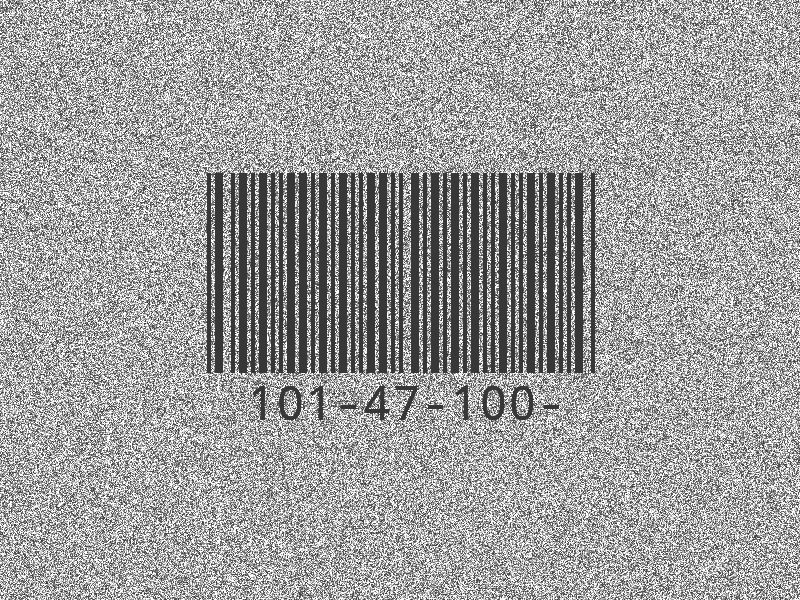

/content/all_images/07 - mal7 w felfel.jpg - True
avgroi = 232 corners_avg = 142.25
/content/all_images/11 - bayza 5ales di bsara7a.jpg - False
avgroi = 248 corners_avg = 148.0
/content/all_images/09 - e3del el soora ya3ammm.jpg - False
avgroi = 228 corners_avg = 99.75
/content/all_images/08 - compresso espresso.jpg - False
avgroi = 243 corners_avg = 136.5
/content/all_images/01 - lol easy.jpg - False
avgroi = 185 corners_avg = 69.25
/content/all_images/05 - meen taffa el nour!!!.jpg - False
avgroi = 236 corners_avg = 88.25
/content/all_images/04 - fen el nadara.jpg - False


In [ ]:
def detect_sltnp(image):
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20*np.log(np.abs(f_transform_shifted))
    #cv2_imshow(magnitude_spectrum)
    rows, cols = image.shape
    center_row = rows // 2
    center_col = cols // 2
    roi_size = 9
    dc_component = magnitude_spectrum[center_row, center_col]
    roi = magnitude_spectrum[center_row - roi_size:center_row + roi_size + 1,
                              center_col - roi_size:center_col + roi_size + 1]
    avg_roi = round(np.mean(roi))
    corner1_avg = round(np.mean(magnitude_spectrum[0:10, 0:10]))
    corner2_avg = round(np.mean(magnitude_spectrum[0:10, -10:]))
    corner3_avg = round(np.mean(magnitude_spectrum[-10:, 0:10]))
    corner4_avg = round(np.mean(magnitude_spectrum[-10:, -10:]))
    corners_avg = (corner1_avg + corner2_avg + corner3_avg + corner4_avg) / 4


    print("avgroi = " + str(avg_roi) + " corners_avg = " + str(corners_avg))



    if(np.mean(magnitude_spectrum[100:-100, 100:-100])== float('-inf')):
        return "FalseINF"

    low_avg_threshold = 200
    high_avg_threshold = 200

# Apply the Laplacian kernel using filter2D


    if(avg_roi > low_avg_threshold and corners_avg > high_avg_threshold):

        cv2_imshow(image)
        return "True"
    else:
        return "False"


print_results(detect_sltnp)

# Detect Frequency (fail)

In [ ]:
def split_image_exclude_center(image, block_size=(25, 25), center_size=(100, 100)):
    """
    Splits the input image into smaller blocks while excluding the central region.

    Args:
        image (numpy.ndarray): The input image.
        block_size (tuple): Size of each block (height, width).
        center_size (tuple): Size of the central region to exclude (height, width).

    Returns:
        list: List of image blocks as numpy arrays.
    """
    h, w = image.shape[:2]  # Image dimensions
    block_height, block_width = block_size
    center_height, center_width = center_size

    # Calculate center region boundaries
    center_row_start = (h - center_height) // 2
    center_row_end = center_row_start + center_height
    center_col_start = (w - center_width) // 2
    center_col_end = center_col_start + center_width

    image_list = []

    # Loop through the image in block_size steps
    for i in range(0, h, block_height):
        for j in range(0, w, block_width):
            # Skip blocks that overlap with the center
            if (center_row_start <= i < center_row_end) and (center_col_start <= j < center_col_end):
                continue

            # Extract block
            block = image[i:i + block_height, j:j + block_width]

            # Ensure the block has the right dimensions (for edges of the image)
            if block.shape[:2] == block_size:
                image_list.append(block)

    return image_list

import numpy as np

def detect_peak_in_blocks(image_list, peak_threshold_factor=0.9):
    """
    Detects peaks in each block of the image list relative to the average intensity of the block.

    Args:
        image_list (list): List of image blocks (numpy arrays).
        peak_threshold_factor (float): Factor to determine what qualifies as a peak.

    Returns:
        list: List of booleans indicating whether each block contains a peak.
    """
    peaks_detected = []

    for block in image_list:
        # Calculate the average intensity of the block
        avg_intensity = np.mean(block)

        # Set the threshold for a peak
        peak_threshold = avg_intensity * peak_threshold_factor

        # Check if any pixel in the block exceeds the threshold
        has_peak = np.any(block > peak_threshold)
        peaks_detected.append(has_peak)

    return len(peaks_detected)

def detect_frequency_issues(image, threshold_factor=0.99):
    # Step 1: Perform FFT and compute the magnitude spectrum
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted) + 1e-10)  # Prevent log(0)

    # Step 2: Normalize the magnitude spectrum to 8-bit range
    magnitude_spectrum = np.uint8(cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX))

    # Step 3: Identify high-frequency components
    rows, cols = magnitude_spectrum.shape
    print("rows = " + str(rows) + " cols = " + str(cols))
    center_row, center_col = rows // 2, cols // 2

    # Define ROI to focus on high-frequency areas (avoid center/low frequencies)
    roi = magnitude_spectrum[center_row - 50:center_row + 50, center_col - 50:center_col + 50] = 0

    # Compute max intensity of FFT spectrum
    max_intensity = np.max(magnitude_spectrum)

    # Isolate high-frequency components (e.g., right half of FFT spectrum)
    high_frequency_component = magnitude_spectrum[:, cols // 2:]
    max_high_frequency_component = np.max(high_frequency_component)

    # Step 4: Compare high-frequency component against a threshold
    noise_threshold = max_intensity * threshold_factor
    is_wave_noise_detected = max_high_frequency_component > noise_threshold

    return str(is_wave_noise_detected)


img = cv2.imread("/content/all_images/03 - eda ya3am ew3a soba3ak mathazarsh.jpg")
imgg= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
f_transform = np.fft.fft2(imgg)
f_transform_shifted = np.fft.fftshift(f_transform)
magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted))  # Prevent log(0)


listaya = split_image_exclude_center(magnitude_spectrum)



count = detect_peak_in_blocks(listaya)
print(count)


#print_results(detect_frequency_issues)

752


# Detect Frequency attempt 2 (works bas metfabrica mooot)


/content/all_images/10 - wen el kontraastttt.jpg - False
/content/all_images/02 - still easy.jpg - False
/content/all_images/03 - eda ya3am ew3a soba3ak mathazarsh.jpg - False
/content/all_images/06 - meen fata7 el nour 333eenaaayy.jpg - False
/content/all_images/07 - mal7 w felfel.jpg - False


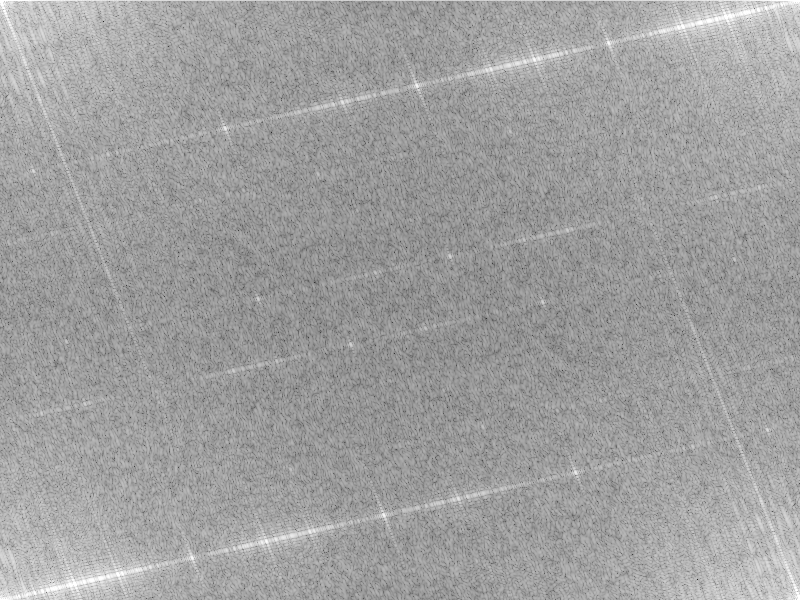

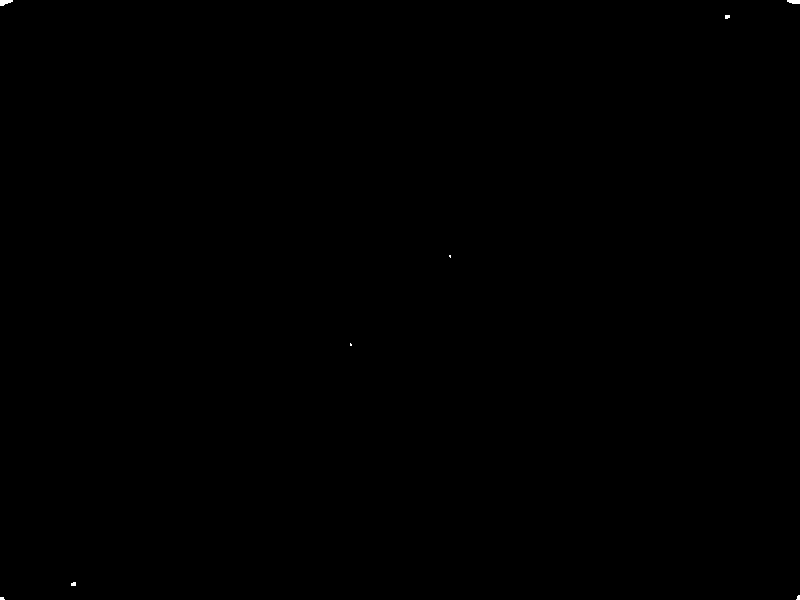

/content/all_images/11 - bayza 5ales di bsara7a.jpg - True
/content/all_images/09 - e3del el soora ya3ammm.jpg - False
/content/all_images/08 - compresso espresso.jpg - False
/content/all_images/01 - lol easy.jpg - False
/content/all_images/05 - meen taffa el nour!!!.jpg - False


<ipython-input-111-f420791aa191>:9: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(f_transform))


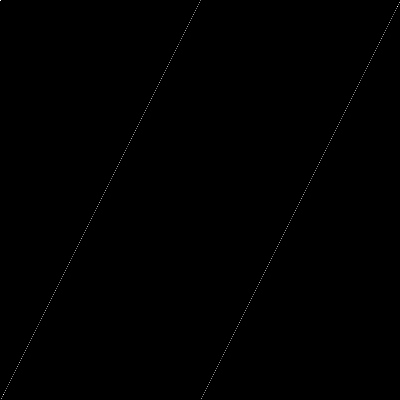

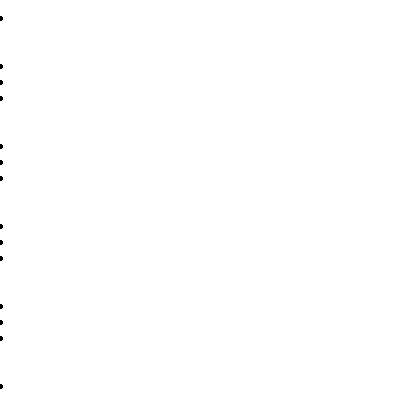

/content/all_images/sine2.png - True
/content/all_images/04 - fen el nadara.jpg - False


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


def detect_frequency(image):
    f_transform = np.fft.fft2(image)
    magnitude_spectrum = 20*np.log(np.abs(f_transform))
    magnitude_spectrum1 = magnitude_spectrum

    magnitude_spectrum = cv2.dilate(magnitude_spectrum, np.ones((3, 3), np.uint16), iterations=2)
    for i in range(6):
      magnitude_spectrum = apply_gaussian(magnitude_spectrum)

    #cv2_imshow(magnitude_spectrum)

    magnitude_spectrum = np.uint8(cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX))


    # histogram = cv2.calcHist([magnitude_spectrum], [0], None, [256], [0, 256])
    # histogram = histogram / histogram.sum()

    # plt.figure(figsize=(10, 5))
    # plt.title("Grayscale Histogram")
    # plt.xlabel("Pixel Intensity")
    # plt.ylabel("Frequency")
    # plt.plot(histogram, color='black')  # Plot the histogram
    # plt.xlim([0, 256])  # Limit x-axis to 256 pixel intensity values
    # plt.grid(True)
    # plt.show()

    center_row, center_col = magnitude_spectrum.shape[0] // 2, magnitude_spectrum.shape[1] // 2
    center_size = 100  # Size of the center region (50x50 pixels)
    threshold_center = 70  # Threshold value for the center region
    threshold_rest = 160  # Threshold value for the rest of the image

    # Step 3: Apply threshold to the center region (ROI)
    magnitude_spectrum[center_row - center_size:center_row + center_size, center_col - center_size:center_col + center_size] = \
        cv2.threshold(magnitude_spectrum[center_row - center_size:center_row + center_size, center_col - center_size:center_col + center_size],
                      threshold_center, 255, cv2.THRESH_BINARY)[1]

    # Step 4: Apply threshold to the rest of the image
    magnitude_spectrum[magnitude_spectrum < threshold_rest] = 0  # Set all pixels below threshold_rest to 0 (black)
    magnitude_spectrum[magnitude_spectrum >= threshold_rest] = 255  # Set all pixels above or equal to threshold_rest to 255 (white)

    # _, binary_image = cv2.threshold(magnitude_spectrum, 140, 255, cv2.THRESH_BINARY)

    #cv2_imshow(magnitude_spectrum)
    if np.any(magnitude_spectrum[center_row - center_size:center_row + center_size, center_col - center_size:center_col + center_size] == 255):  # Check if any white pixel exists in the center region
      cv2_imshow(magnitude_spectrum1)
      cv2_imshow(magnitude_spectrum)
      return "True" # White pixel found in center region
    else:
      return "False"

print_results(detect_frequency)

# PREPROCESSING FUNCTIONS




In [ ]:
def grey_scale(image):
  imageg=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return imageg


In [ ]:
def thresholding(image):
  ret,thresh1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
  return thresh1

In [ ]:
def remove_Obstacle(image):
  # Convert to grayscale
  gray = grey_scale(image)
  # Set all non-black and non-white pixels to white

  gray[(gray >= 20) & (gray <= 220)] = 255
  cv2_imshow(gray)
  gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))
  cv2_imshow(gray)
  grayf = cv2.morphologyEx(gray, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 200)))
  cv2_imshow(grayf)
  return grayf


In [ ]:
  def crop_rows(image, num_rows=2):

    if image.shape[0] <= 2 * num_rows:
        raise ValueError("Image has fewer rows than twice the number of rows to crop.")

    # Crop rows
    contoured= contour(image)
    cropped_image = contoured[num_rows:-num_rows, :]
    return cropped_image

In [ ]:

def process_dark_barcode(image):

    # Step 1: Thresholding to create an inverse binary mask
    _, binary_image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)

    # Step 2: Inpainting the image based on the binary mask
    inpainted_image = cv2.inpaint(image, binary_image, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Step 3: Create a mask of brighter regions
    _, bright_mask = cv2.threshold(inpainted_image, 10, 255, cv2.THRESH_BINARY)

    # Step 4: Lighten the image using the mask
    lightened_image = np.where(bright_mask == 255,
                               np.clip(inpainted_image * 4, 0, 255).astype(np.uint8),
                               inpainted_image)

    # Step 5: Create a final binary mask for the barcode
    _, binary_result = cv2.threshold(lightened_image, 50, 255, cv2.THRESH_BINARY)

    # Step 6: Get the height of the vertical bar
    bar_height = calculate_vertical_bar_height(binary_result)

    # Step 7: Apply closing and opening using the calculated bar height
    closed_image = apply_closing(binary_result, bar_height)
    opened_image = apply_opening(closed_image, bar_height)

    # Further processing steps
    cropped = crop_rows(opened_image, 5)
    threshed = thresholding(cropped)

    return threshed
"""
    def process_dark_barcode(image):

    # Step 1: Thresholding to create an inverse binary mask
    _, binary_image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)

    # Step 2: Inpainting the image based on the binary mask
    inpainted_image = cv2.inpaint(image, binary_image, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Step 3: Create a mask of brighter regions
    _, bright_mask = cv2.threshold(inpainted_image, 10, 255, cv2.THRESH_BINARY)

    # Step 4: Lighten the image using the mask
    lightened_image = np.where(bright_mask == 255,
                               np.clip(inpainted_image * 4, 0, 255).astype(np.uint8),
                               inpainted_image)

    # Step 5: Create a final binary mask for the barcode
    _, binary_result = cv2.threshold(lightened_image, 50, 255, cv2.THRESH_BINARY)
    contoured=contour(binary_result)

    if len(contoured.shape) == 2:
      height, width = contoured.shape
      channels = 1  # Grayscale
    else:
      height, width, channels = contoured.shape

    close = cv2.morphologyEx(binary_result, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))
    open = cv2.morphologyEx(close, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (2, height)))

    cropped=crop_rows(open,5)
    threshed=thresholding(cropped)
    return threshed
"""





'\n    def process_dark_barcode(image):\n\n    # Step 1: Thresholding to create an inverse binary mask\n    _, binary_image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)\n\n    # Step 2: Inpainting the image based on the binary mask\n    inpainted_image = cv2.inpaint(image, binary_image, inpaintRadius=3, flags=cv2.INPAINT_TELEA)\n\n    # Step 3: Create a mask of brighter regions\n    _, bright_mask = cv2.threshold(inpainted_image, 10, 255, cv2.THRESH_BINARY)\n\n    # Step 4: Lighten the image using the mask\n    lightened_image = np.where(bright_mask == 255,\n                               np.clip(inpainted_image * 4, 0, 255).astype(np.uint8),\n                               inpainted_image)\n\n    # Step 5: Create a final binary mask for the barcode\n    _, binary_result = cv2.threshold(lightened_image, 50, 255, cv2.THRESH_BINARY)\n    contoured=contour(binary_result)\n\n    if len(contoured.shape) == 2:\n      height, width = contoured.shape\n      channels = 1  # Grayscale

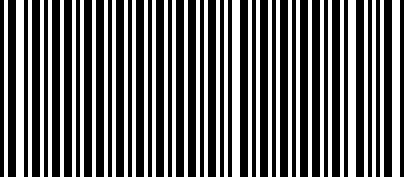

In [ ]:
img = cv2.imread("/content/all_images/05 - meen taffa el nour!!!.jpg")
imgg= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

result= process_dark_barcode(imgg)
cv2_imshow(result)

In [ ]:

def gamma_correction(image, gamma):
    """
    Applies gamma correction to an image.
    Args:
        image (numpy array): Input grayscale or color image.
        gamma (float): Gamma value for correction (e.g., <1 for brightening, >1 for darkening).
    Returns:
        numpy array: Gamma-corrected image.
    """
    # Step 1: Build a Look-Up Table (LUT) for gamma correction
    lookUpTable = np.empty((1, 256), np.uint8)
    for i in range(256):
        lookUpTable[0, i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)

    # Step 2: Apply the LUT to the image
    corrected_image = cv2.LUT(image, lookUpTable)
    cropped=crop_rows(corrected_image,10)
    threshed=thresholding(cropped)
    return threshed


In [ ]:
img = cv2.imread("/content/06 - meen fata7 el nour 333eenaaayy.jpg")
imgg= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img)
result= gamma_correction(imgg,30)

cv2_imshow(result)

In [ ]:

def sheel_mal7_wfelfel(image):
    # Convert the image to grayscale first
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred_image = cv2.blur(gray_image, (1, 15))
    filtered_image = cv2.medianBlur(blurred_image, 5)

    _, filtered_thresh = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    cropped=crop_rows(filtered_thresh,5)
    threshed=thresholding(cropped)

    return threshed

# Load the image
img = cv2.imread("/content/07 - mal7 w felfel.jpg")

# Show the original image
cv2_imshow(img)

# Process the image to remove salt-and-pepper noise
result = sheel_mal7_wfelfel(img)

cv2_imshow(result)


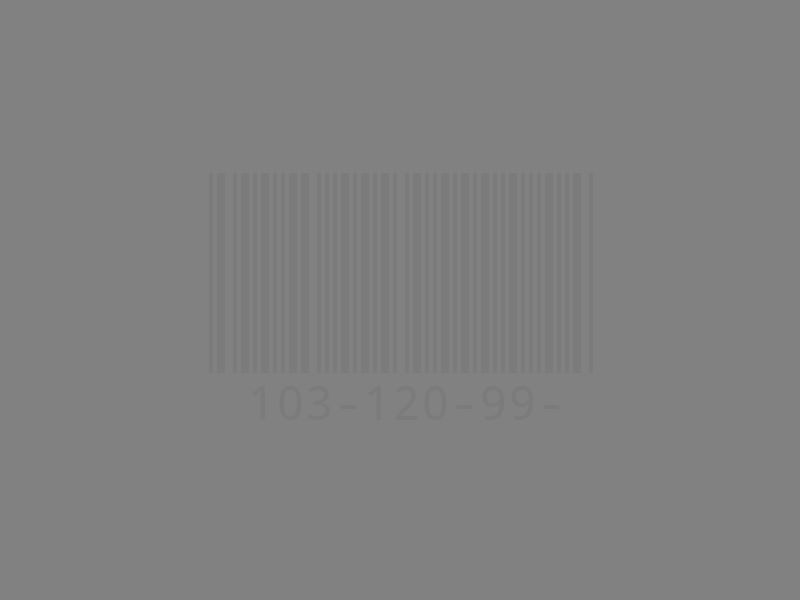

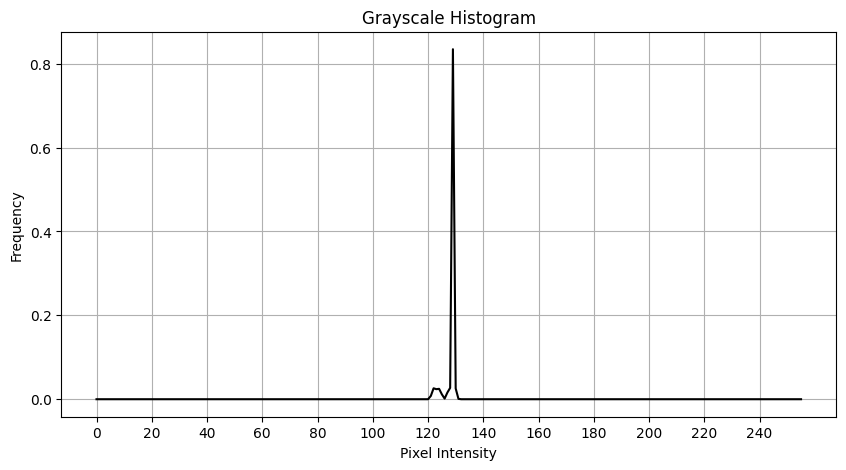

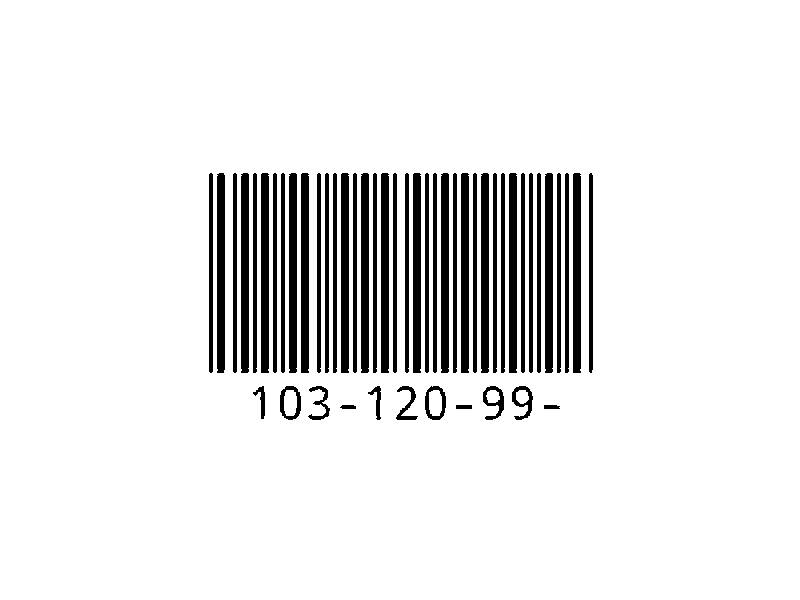

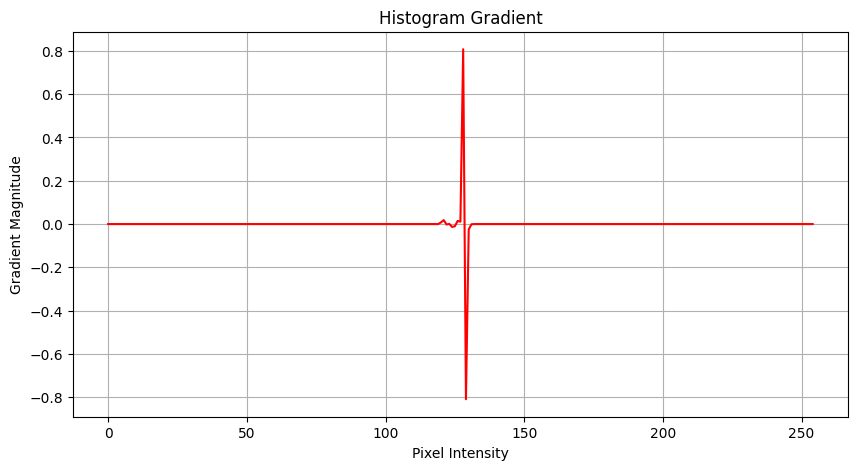

Midpoint intensity: 124.5


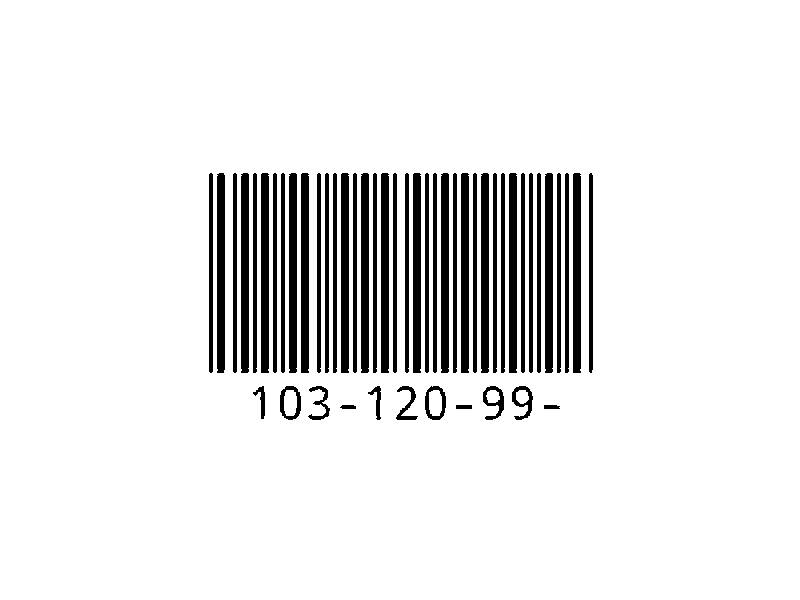

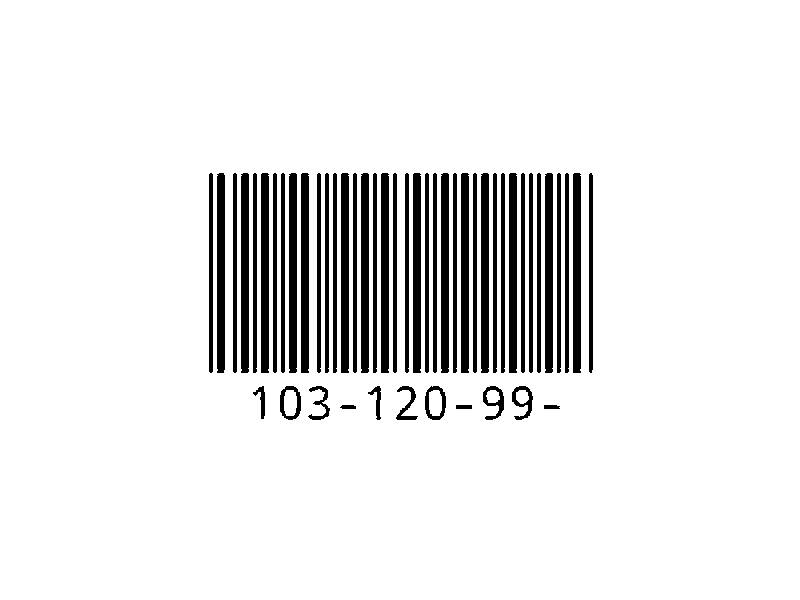

In [ ]:
def la2ena_el_contrast(image) :

    # Convert image to grayscale
    imgg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2_imshow(imgg)  # Show grayscale image for reference

    # Plot the histogram
    histogram = cv2.calcHist([imgg], [0], None, [256], [0, 256])
    histogram = histogram / histogram.sum()  # Normalize
    plt.figure(figsize=(10, 5))
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.plot(histogram, color='black')  # Plot the histogram
    plt.xticks(ticks=np.arange(0, 256, 20))  # Adjust x-axis tick intervals
    plt.grid(True)
    plt.show()

    # Apply threshold
    _, threshed = cv2.threshold(imgg, 125, 255, cv2.THRESH_BINARY)  # Binary threshold
    cv2_imshow(threshed)  # Show thresholded image for debugging

    # (Optional) Calculate and plot the difference in histograms (gradient)
    histogram_diff = np.diff(histogram.ravel())
    plt.figure(figsize=(10, 5))
    plt.title("Histogram Gradient")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Gradient Magnitude")
    plt.plot(histogram_diff, color='red')
    plt.grid(True)
    plt.show()

    # Find the peaks in the histogram difference (local maxima of pixel intensities)
    peaks, _ = find_peaks(histogram_diff)

    # Get the heights (values) of the peaks
    peak_values = histogram_diff[peaks]

    # Find the two highest peaks (pixel intensities)
    highest_peaks_indices = peaks[np.argsort(peak_values)[-2:]]  # Sort and pick top 2
    highest_peaks_values = highest_peaks_indices  # Pixel intensity values are the indices

    # Calculate the midpoint of the two highest intensity peaks
    midpoint_intensity = np.mean(highest_peaks_values)

    # Return midpoint intensity value for further use
    print(f"Midpoint intensity: {midpoint_intensity}")


    # Apply threshold
    _, threshed = cv2.threshold(imgg, math.ceil(midpoint_intensity), 255, cv2.THRESH_BINARY)  # Binary threshold
    cv2_imshow(threshed)  # Show thresholded image for debugging
    return threshed


img = cv2.imread("/content/all_images/10 - wen el kontraastttt.jpg")
result= la2ena_el_contrast(img)

cv2_imshow(result)

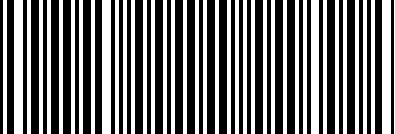

In [ ]:
def crop_rows(image, num_rows=2):

    if image.shape[0] <= 2 * num_rows:
        raise ValueError("Image has fewer rows than twice the number of rows to crop.")

    # Crop rows
    contoured= contour(image)
    cropped_image = contoured[num_rows:-num_rows, :]
    return cropped_image

def decompresso_espresso (image):

  imgg= grey_scale(image)
  threshed= thresholding(imgg)
  contoured= contour(threshed)
  cropped = crop_rows(contoured,3)
  return cropped

img = cv2.imread("/content/all_images/08 - compresso espresso.jpg")

result= decompresso_espresso(img)
cv2_imshow(result)

Maximum Magnitude: 81761108.0
Cutoff Magnitude: 8176110.800000001


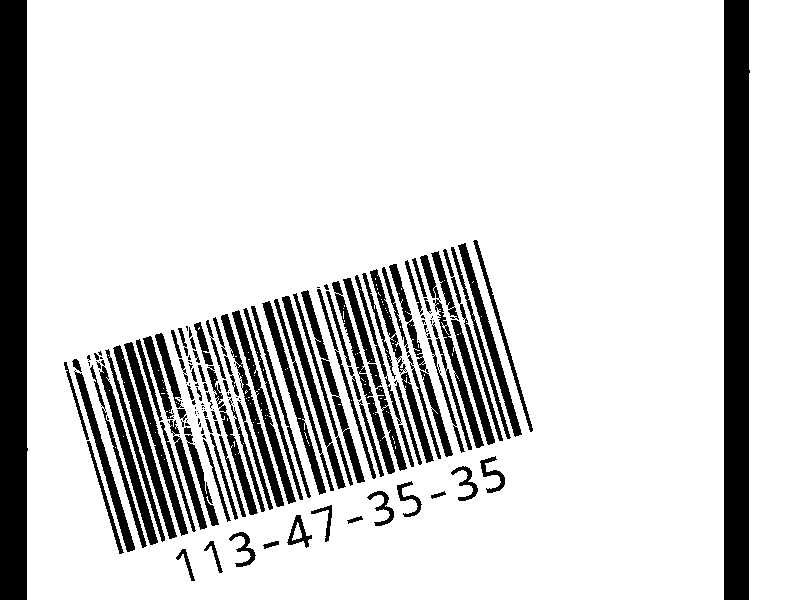

'"\nfiltered_image = cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2BGR)\ncontoured=contour_rotated(filtered_image)\ncv2_imshow(contoured) \n'

In [ ]:
def periodic_noise_removal(img, threshold=0.1):

    # Step 1: Apply FFT and shift the zero frequency component to the center
    fft_image = fftpack.fft2(img)
    fft_shifted = fftpack.fftshift(fft_image)

    # Step 2: Calculate the magnitude spectrum
    magnitude_spectrum = np.abs(fft_shifted)

    # Step 3: Get the maximum magnitude of the spectrum
    max_magnitude = np.max(magnitude_spectrum)
    print(f"Maximum Magnitude: {max_magnitude}")

    # Step 4: Create a high-pass filter (circular mask) centered at the middle of the image
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2  # Center of the image

    # Create a mask for the high-pass filter (start with all ones)
    mask = np.ones((rows, cols), dtype=np.float32)

    # Use maximum magnitude to calculate a threshold for low frequencies
    cutoff_magnitude = max_magnitude * threshold  # This threshold uses the max magnitude
    print(f"Cutoff Magnitude: {cutoff_magnitude}")
    # Set the low-frequency region (center) to zero if the magnitude is below the threshold
    mask[magnitude_spectrum >= cutoff_magnitude] = 0

    # Step 5: Apply the high-pass filter to the shifted frequency spectrum
    f_transform_shifted_filtered = fft_shifted * mask

    # Step 6: Shift back the zero frequency component to its original position
    f_transform_filtered = np.fft.ifftshift(f_transform_shifted_filtered)

    # Step 7: Compute the inverse FFT to get the filtered image (real part)
    filtered_image = np.fft.ifft2(f_transform_filtered).real

    # Step 8: Normalize the filtered image for better display
    filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


    # Step 9: Apply thresholding to create a binary image
    _, threshed = cv2.threshold(filtered_image, 128, 255, cv2.THRESH_BINARY)

    return threshed


# Example usage:
input_image = cv2.imread('/11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
filtered_image = periodic_noise_removal(input_image, 0.1)
cv2_imshow(filtered_image)
""""
filtered_image = cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2BGR)
contoured=contour_rotated(filtered_image)
cv2_imshow(contoured)
"""


# Ya Rab


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load a grayscale image
image = cv2.imread('/content/all_images/11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)

# Extract a specific row (e.g., 100th row)
row = image[480, :]

# Compute the gradient
gradient = np.gradient(row)

# Compute magnitude and angle
magnitude = np.abs(gradient)
angle = np.arctan(gradient)
angle_degrees = np.degrees(angle)

# Visualize the row and its gradient
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(row, label='Row Intensity')
plt.title('Row Intensity')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(magnitude, label='Gradient Magnitude')
plt.plot(angle_degrees, label='Gradient Angle (degrees)')
plt.title('Gradient Magnitude & Angle')
plt.legend()

plt.show()


In [ ]:
 import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load a grayscale image
# Replace 'your_image.png' with the path to your image
image = cv2.imread('/content/all_images/11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE)
listoflists = []
# If the image is not loaded, use a random matrix for demonstration
if image is None:
    image = np.random.randint(0, 255, (200, 200), dtype=np.uint8)

# Apply Sobel filter to compute gradients
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in the X direction
for i in range(image.shape[0]):
    row_gradient = sobel_x[i, :]  # Extract gradient for the specific row
    magnitude = np.abs(row_gradient)  # Compute the magnitude of the gradient
    angle = np.arctan(row_gradient)  # Compute the angle of the gradient

    # Append both the magnitude and angle as pairs for each row
    listoflists.append([magnitude.tolist(), angle.tolist()])  # Convert arrays to lists



print(listoflists[0])



[[0.0, 8.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 20.0, 24.0, 24.0, 28.0, 28.0, 20.0, 20.0, 24.0, 28.0, 28.0, 24.0, 28.0, 32.0, 32.0, 28.0, 28.0, 28.0, 28.0, 32.0, 32.0, 28.0, 28.0, 28.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 20.0, 16.0, 16.0, 20.0, 20.0, 20.0, 16.0, 8.0, 4.0, 8.0, 12.0, 8.0, 8.0, 4.0, 0.0, 0.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 8.0, 12.0, 8.0, 16.0, 20.0, 16.0, 16.0, 16.0, 20.0, 16.0, 16.0, 24.0, 24.0, 24.0, 28.0, 28.0, 24.0, 24.0, 24.0, 28.0, 28.0, 28.0, 32.0, 32.0, 28.0, 28.0, 28.0, 28.0, 32.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 24.0, 20.0, 20.0, 24.0, 24.0, 24.0, 20.0, 20.0, 20.0, 16.0, 12.0, 12.0, 12.0, 8.0, 12.0, 12.0, 4.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 8.0, 12.0, 8.0, 4.0, 8.0, 8.0, 12.0, 12.0, 16.0, 24.0, 20.0, 20.0, 20.0, 20.0, 24.0, 24.0, 20.0, 24.0, 28.0, 28.0, 28.0, 28.0, 28.0, 24.0, 28.0, 32.0, 28.0, 28.0, 32.0, 28.0, 28.0, 28.0, 28.0, 32.0, 32.0, 28.0, 24.0, 24.0, 24.0, 20.0, 24.0, 28.0, 24.0, 24.0, 20.0, 16.0, 12.0, 12.0,